# Exploration and Skill Acquisition in a Major Online Game

* Tom Stafford; University of Sheffield, t.stafford@shef.ac.uk
* Sam Devlin; Digital Creativity Labs, University of York
* Anders Drachen; Digital Creativity Labs, University of York
* Rafet Sifa; Fraunhofer IAIS, Germany

### Tracking skill acquisition across 21,543 players of the first-person shooter game Destiny shows that variability in some – but not all – dimensions of practice enhances learning

### CogSci17: 39th Annual Meeting of the Cognitive Science Society, London, UK,  July 26th – July 29th, 2017
### Poster 140, Poster Session 1, Monarch Suite, Thursday, July 27, 1:20pm – 2:50pm

Paper: https://mindmodeling.org/cogsci2017/papers/0615/index.html  
Full scripts & sample data: https://osf.io/c59n9/  
Poster: http://tomstafford.staff.shef.ac.uk/docs/CogSci17_TomStafford.jpg  
This notebook: https://github.com/tomstafford/destiny/blob/master/variability.ipynb  

This code walks you through the main visualisations of the paper - if you want the full details you need to check out the scripts on the OSF and read the PDF. This is the abridged version, showing that raised variability in some, but not all aspects of the way a player can practice the game are associated with reaching greater levels of performance and/or improving performance faster.

Ready? Let's go!

## Initialise

In [1]:
#libraries
# - standard
import os #directory and file functions
import socket #machine id
import pandas as pd #data munging 
import sys #for getting Python version
import numpy as np #number functions
import matplotlib #graphing settings
import pylab as plt #graphing functions
import scipy.stats as stats #statistical functions

#Using arrow instead of datetime because @treycausey told me to
#http://crsmithdev.com/arrow/
import arrow

# - bespoke
from destiny_funcs import maketime, ranker, tagger, correlate, findspacing

#suppress warnings, for tidyiness
import warnings; warnings.simplefilter('ignore')

print("Python version = " + sys.version)
print("working directory = " + os.getcwd())
print("Machine = " + socket.gethostname())

Python version = 3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609]
working directory = /home/tom/Dropbox/university/expts/destiny_public/destiny
Machine = tom-xps


In [2]:
# Parameters
logtransform = False

# Graph settings
%matplotlib inline
matplotlib.rcParams['figure.figsize']=[18,12]
#all graphs to have same x y range
xmin=0.5 
xmax=1.1

cRmin=60;cRmax=130
if logtransform:
    cRmin=np.log(60);cRmax=np.log(130)

perfvar='combatRating' #'killsDeathsRatio'
if logtransform:
    perfvar='Ln_combatRating' #'killsDeathsRatio'

## The Data

In [3]:
#----------------- full data not publically available (sorry!)

local=True
if local:
    filepath='../../destiny/data/validation_dataset/' #location of full dataset on Tom's machine
    dfilename='validation-dataset-rldat.csv' 
    gfilename='grimScore_validationPlayers.csv'
    pfilename='validation-dataset-entropyAcrossEventTypesForFirst25Days.csv'

df=pd.read_csv(filepath+dfilename) #main player data

gf=pd.read_csv(filepath+gfilename) #final grimoire score of each player
gf.columns= ['userid','grimscore']

pf=pd.read_csv(filepath+pfilename) #entropy across playmodes
pf.columns= ['userid','eventEntropy25']

In [4]:
df.head() #example of what the data look like (nb not all columns shown)

,destinyMembershipId,date,PvPEventCount,totalDeathDistance,activitiesWon,totalKillDistance,deaths,averageLifespan,objectivesCompleted,averageKillDistance,...,assists,resurrectionsReceived,activitiesEntered,score,averageScorePerLife,maximumWeaponLevel,allParticipantsCount,maximumPowerLevel,highestCharacterLevel,winLossRatio
0,4611686018428705658,2015-12-01T00:00:00Z,1,0,22,8023,216,75.723502,32,17.868597,...,90,16,31,93182,429.410138,0,245,0,40,2.444444
1,4611686018428705658,2015-12-02T00:00:00Z,2,0,0,275,17,39.555556,3,16.176471,...,6,0,1,3695,205.277778,0,16,0,40,0.000000
2,4611686018428705658,2015-12-03T00:00:00Z,3,0,1,254,1,193.500000,0,13.368421,...,1,0,1,2505,1252.500000,0,6,0,40,-1.000000
3,4611686018428705658,2015-12-04T00:00:00Z,4,0,18,5873,106,124.130841,0,30.273196,...,33,42,25,103,0.962617,0,150,0,40,2.571429
4,4611686018428705658,2015-12-08T00:00:00Z,5,0,7,2781,104,62.038095,1,17.490566,...,22,3,10,23625,225.000000,0,85,0,40,2.333333


## Data Munging

In [5]:
#our headings
cols=df.columns.values

print("Rows in dataset   = " + str(len(df)))
print("Unique player IDs = " + str(len(df[cols[0]].unique())))

#create a unique timestamp for each play
df['time'] =df.apply(maketime, axis=1)

#use this to create a sequential count of each game, for each player
df.sort_values('time', ascending=True, inplace=True)
df=df.groupby('destinyMembershipId').apply(ranker)
#now find some by player stats
df=df.groupby('destinyMembershipId').apply(tagger)

Rows in dataset   = 703602
Unique player IDs = 12861


In [6]:
#now let's filter players by minimum games played  and remove games beyond this
minimum_plays=49
sf=df[(df['max_plays']>minimum_plays) & (df['game_n']<(minimum_plays+2))]
labeltext=str(len(sf['destinyMembershipId'].unique())) + ' players'

if logtransform:
    sf['Ln_combatRating']=np.log(sf['combatRating'])

## Figure 1: Learning Curves

Repeating the analysis of Stafford & Dewar (2014), we divide players by their highest ever performance, and then trace the evolution of their performance across time.

NOT DONE for nan


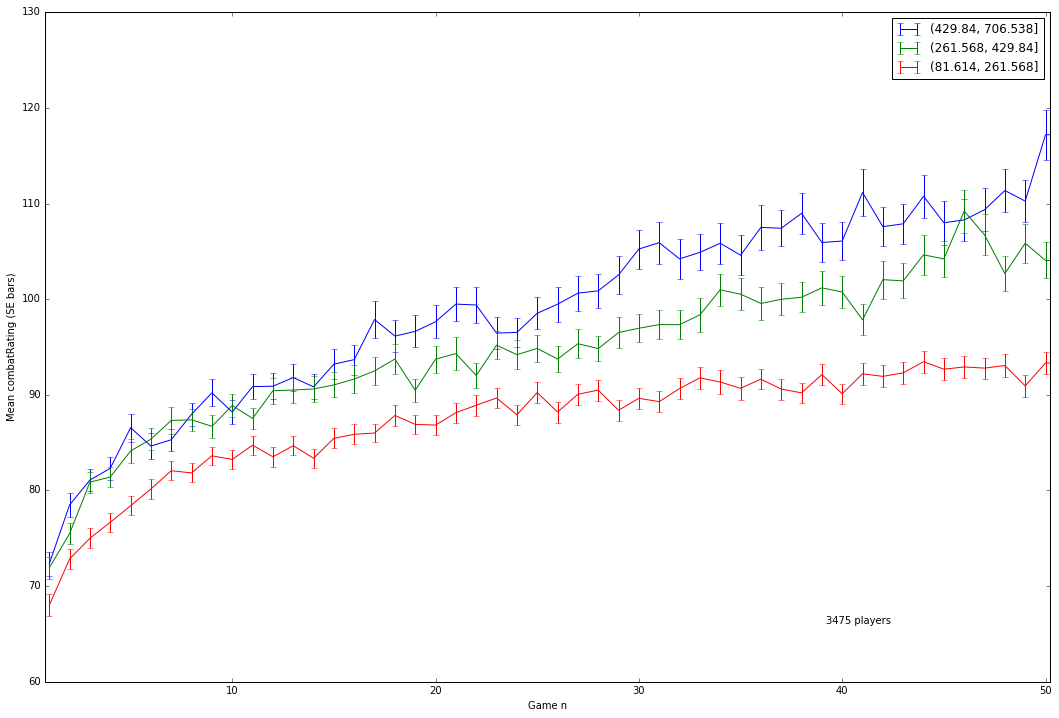

In [7]:
#find divisions between thirds on top scores
percentiles = [stats.scoreatpercentile(sf['top_cr_'].values, per) for per in range(0,120,33)]

#label players according to this
#sf.loc[:,'score_cat']=pd.cut(sf['top_cr_'],percentiles) #produces warning "Try using .loc[row_indexer,col_indexer] = value instead"

sf['score_cat']=pd.cut(sf['top_cr_'],percentiles) #produces warning "Try using .loc[row_indexer,col_indexer] = value instead"


#this would be better done using seaborn.tsplot
plt.clf()
for cat in sf['score_cat'].unique():
    try:
        mask=(sf['score_cat']==cat) & (sf['game_n']<(minimum_plays+2)) & np.isfinite(sf[perfvar])
        xvals=list(range(1,minimum_plays+2))
        #yvals=sf[mask].groupby('game_n')['killsDeathsRatio'].mean()    
        #ysems=sf[mask].groupby('game_n')['killsDeathsRatio'].sem()    
        yvals=sf[mask].groupby('game_n')[perfvar].mean()    
        ysems=sf[mask].groupby('game_n')[perfvar].sem()    
        xvals.append(10000);yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
        plt.errorbar(xvals,yvals,yerr=ysems,label=cat)
    except:
        print("NOT DONE for " + str(cat))

plt.xlim([0.8,minimum_plays+1.2])
plt.ylim([cRmin,cRmax])
plt.xlabel('Game n')
plt.ylabel('Mean ' + str(perfvar) + ' (SE bars)')
plt.annotate(labeltext,xy=(minimum_plays*0.8, cRmin*1.1),xycoords='data')
plt.legend(loc=0);

Note how those who go on to have the highest scores (in blue) start off with superior performance on their first play, and increase their performance faster with practice

## Figure 2: Spacing (exploration of practice scheduling)


Do those who spread their practice/plays outperform those who cramming them together (ie not taking breaks)? 

Spoiler: yes.

In [8]:
'''
now we're going to make a df of player, not game, level statistics
'''

#get max plays per ID
players=sf.groupby('destinyMembershipId')['max_plays'].mean().reset_index()

sf=sf.groupby('destinyMembershipId').apply(findspacing,25) #get spacing of first 25 games

In [9]:
players=players.merge(sf[['destinyMembershipId','space25']].drop_duplicates(),how='left',left_on='destinyMembershipId',right_on='destinyMembershipId')

#figure out quartiles of grimoire score for each play level
q1=players['space25'].quantile(0.25)
q2=players['space25'].quantile(0.5)
q3=players['space25'].quantile(0.75)

minplay=50
maxplay=500
#divide all players according to weather they score above or below expected on their grimscore
spacers_=players[players['space25']>q3]['destinyMembershipId']
groupers=players[players['space25']<q1]['destinyMembershipId']

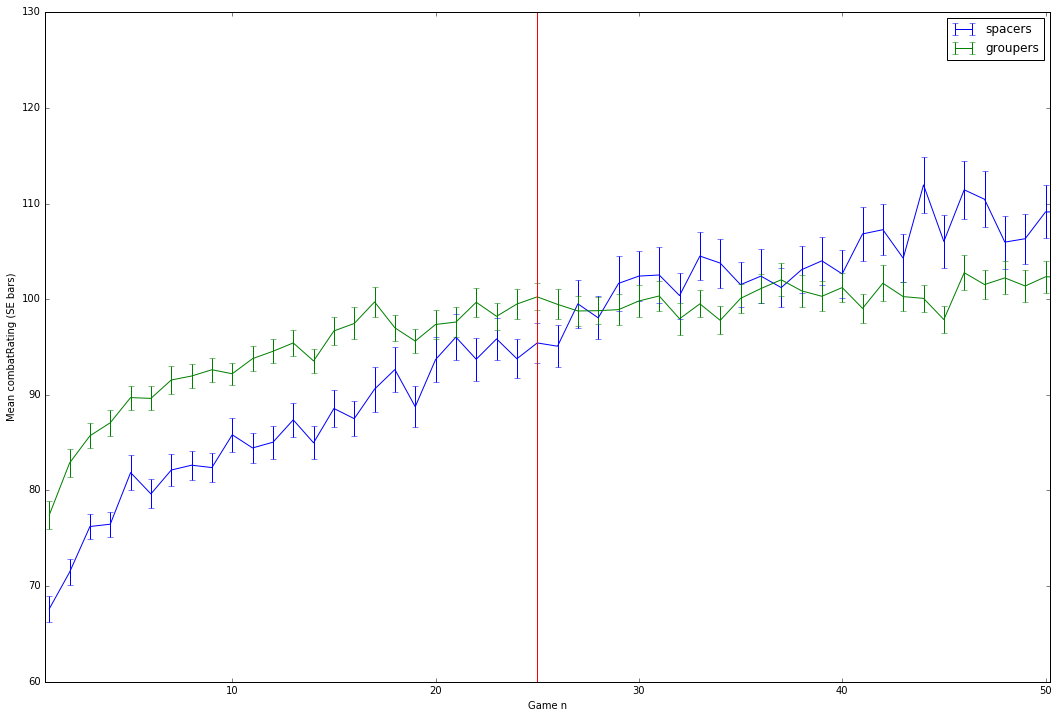

In [10]:
groups=[spacers_,groupers]
labels=['spacers','groupers']

plt.clf()
for i,group in enumerate(groups):
    mask=(sf['destinyMembershipId'].isin(group)) & (sf['max_plays']>(minplay)) & (sf['max_plays']<(maxplay)) & np.isfinite(sf[perfvar])
    xvals=list(range(1,minplay+1))    
    yvals=sf[mask].groupby('game_n')[perfvar].mean()    
    ysems=sf[mask].groupby('game_n')[perfvar].sem()    
    yvals=yvals[:minplay];ysems=ysems[:minplay]
    xvals.append(100000);yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
    plt.errorbar(xvals,yvals,yerr=ysems,label=labels[i])
    

plt.plot([25,25],[cRmin,cRmax],'-',color='red')
plt.xlim([0.8,minplay+0.2])
plt.ylim([cRmin,cRmax])
plt.xlabel('Game n')
plt.ylabel('Mean ' + str(perfvar) + ' (SE bars)')
plt.legend(loc=0);


Splitting the groups on the amount of spacing in the first 25 games shows that those in the top 25% for spacing learn faster in the following period

# Figure 3: exploration of game world

The "grimoire score" is a measure of how much players explore the game world. I thought it could be used as a proxy for curiosity - a trait measure of a tendency to explore. 

In [11]:
#merge with grimoire scores
#some players have user IDs but not in rldat.csv
players=players.merge(gf,how='left',left_on='destinyMembershipId',right_on='userid')

In [12]:
players.head()

,destinyMembershipId,max_plays,space25,userid,grimscore
0,4611686018428395647,121,158,4.611686e+18,4490
1,4611686018428395829,66,228,4.611686e+18,3110
2,4611686018428399028,229,97,4.611686e+18,4055
3,4611686018428401319,147,275,4.611686e+18,4410
4,4611686018428402622,72,70,4.611686e+18,3685


In [13]:
#figure out quartiles of grimoire score for each play level
q1=players.groupby('max_plays')['grimscore'].quantile(0.25)
q2=players.groupby('max_plays')['grimscore'].quantile(0.5)
q3=players.groupby('max_plays')['grimscore'].quantile(0.75)

minplay=50
maxplay=500
#divide all players according to whether they score above or below expected on their grimscore
explorers_=players[players['grimscore']>q3[players['max_plays']]]['destinyMembershipId']
exploiters=players[players['grimscore']<q1[players['max_plays']]]['destinyMembershipId']

#Of course, we could do this - it doesn't make a difference
#explorers_=players[players['grimZ']>1]['destinyMembershipId']
#exploiters=players[players['grimZ']<1]['destinyMembershipId']


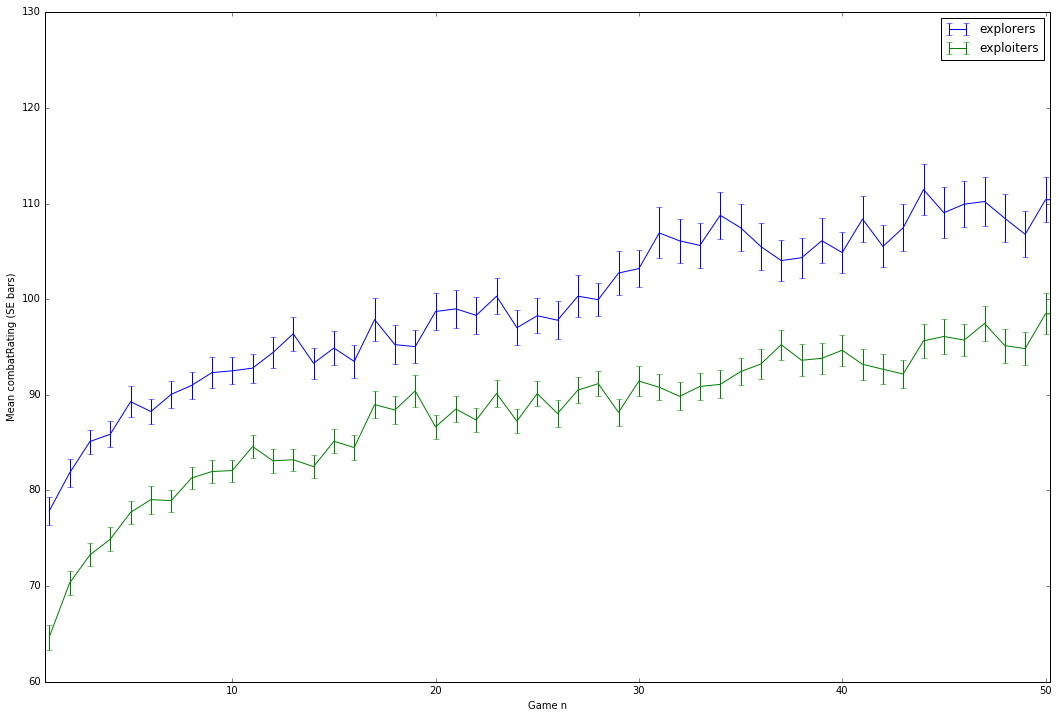

In [14]:
groups=[explorers_,exploiters]
labels=['explorers','exploiters']
plt.clf()

for i,group in enumerate(groups):
    mask=(sf['destinyMembershipId'].isin(group)) & (sf['max_plays']>(minplay)) & (sf['max_plays']<(maxplay)) & np.isfinite(sf[perfvar])
    xvals=list(range(1,minplay+1))
    yvals=sf[mask].groupby('game_n')[perfvar].mean()    
    ysems=sf[mask].groupby('game_n')[perfvar].sem()    
    yvals=yvals[:minplay];ysems=ysems[:minplay]
    xvals.append(100000);yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
    plt.errorbar(xvals,yvals,yerr=ysems,label=labels[i])

plt.xlim([0.8,minplay+0.2])
plt.ylim([cRmin,cRmax])
plt.xlabel('Game n')
plt.ylabel('Mean ' + str(perfvar) + ' (SE bars)')
plt.legend(loc=0);

Players who start off better at the game explore more, but there's no indication that exploring more faciliated a greater learning rate.

In [15]:
'''
Calculate, for each player, a  grimscore Z score 
(normalised against distribution for all players with that number of plays)
'''

grim_mu=players.groupby('max_plays')['grimscore'].mean()
grim_sigma=players.groupby('max_plays')['grimscore'].std()

players['grimZ']=(players['grimscore']-grim_mu[players['max_plays']].values)/grim_sigma[players['max_plays']].values

## Figure 4 :  Exploration in play style: social play

Destiny records both your 'kills' but also your 'assists' (when you are near when another player makes a kill). By dividing players on their number of assists in their first 25 games, perhaps we can index propensity to explore the social aspects of the game. 

In [16]:
sf['assistsX']=sf['killsDeathsAssists']-sf['killsDeathsRatio']

In [17]:
players=players.merge(sf[sf['game_n']<26].groupby('destinyMembershipId')['assistsX'].sum().reset_index(), how='left',left_on='destinyMembershipId',right_on='destinyMembershipId')
players['assists_rate']=players['assistsX']/25

mask=~players['assists_rate'].isnull()
q1=players[mask]['assists_rate'].quantile(0.25)
q2=players[mask]['assists_rate'].quantile(0.5)
q3=players[mask]['assists_rate'].quantile(0.75)

minplay=50
maxplay=100
#divide all players according to weather they score above or below expected on their grimscore
packplayers=players[players['assists_rate']>q1]['destinyMembershipId']
lonewolves_=players[players['assists_rate']<q3]['destinyMembershipId']

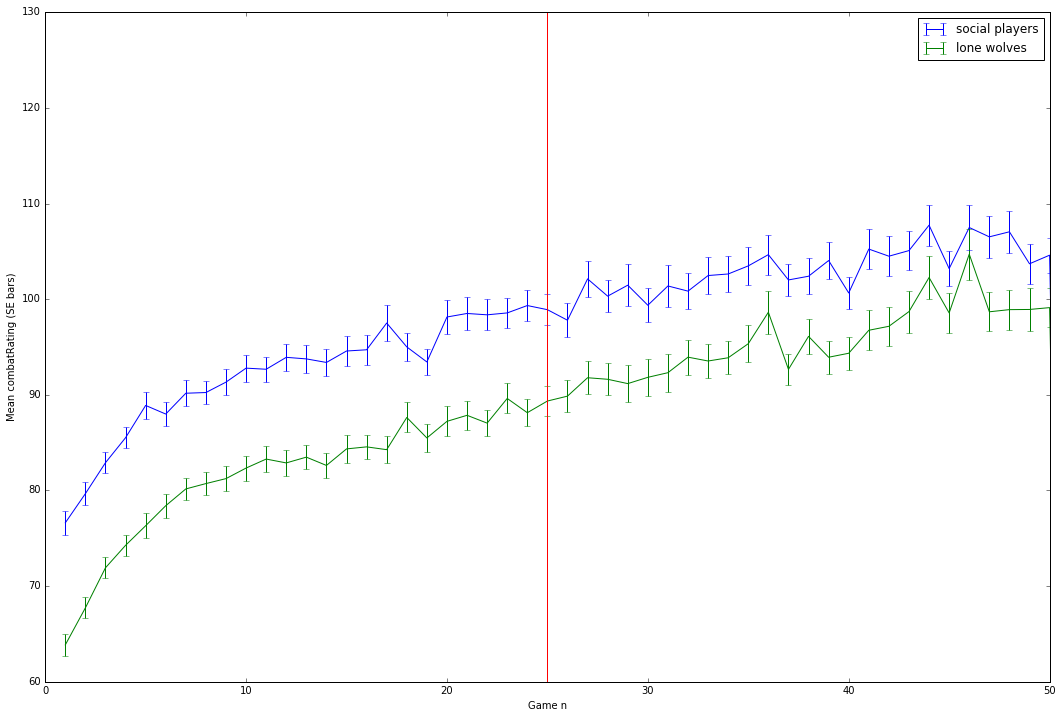

In [18]:
plt.clf()
xvals=list(range(1,minplay+2))

mask=(sf['destinyMembershipId'].isin(packplayers)) & (sf['max_plays']>(minplay)) & (sf['max_plays']<(maxplay)) & np.isfinite(sf[perfvar])
yvals=sf[mask].groupby('game_n')[perfvar].mean()    
ysems=sf[mask].groupby('game_n')[perfvar].sem()    
yvals=yvals[:minplay];ysems=ysems[:minplay]
yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
plt.errorbar(xvals,yvals,yerr=ysems,label='social players')

mask=(sf['destinyMembershipId'].isin(lonewolves_)) & (sf['max_plays']>(minplay)) & (sf['max_plays']<(maxplay)) & np.isfinite(sf[perfvar])
yvals=sf[mask].groupby('game_n')[perfvar].mean()    
ysems=sf[mask].groupby('game_n')[perfvar].sem()    
yvals=yvals[:minplay];ysems=ysems[:minplay]
yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
plt.errorbar(xvals,yvals,yerr=ysems,label='lone wolves')

plt.plot([25,25],[cRmin,cRmax],'-',color='red')
plt.xlim([0,minplay])
plt.ylim([cRmin,cRmax])
plt.xlabel('Game n')
plt.ylabel('Mean ' + perfvar + ' (SE bars)')
#plt.annotate(labeltext,xy=(minimum_plays*0.8, .55),xycoords='data')
plt.legend(loc=0);

If anything, propensity to social play predicts *decreased* learning on subsequent games

## Figure 5: Exploration in play mode
    
Destiny has several play modes: raids, quests, player vs player etc. We calculate the entropy of each players distribution of their time over these play modes and then use this as an index of their propensity to explore the play modes

In [19]:
players=players.merge(pf,how='left',left_on='destinyMembershipId',right_on=['userid'])

In [20]:
mask=~players['eventEntropy25'].isnull()
q1=players[mask]['eventEntropy25'].quantile(0.25)
q2=players[mask]['eventEntropy25'].quantile(0.5)
q3=players[mask]['eventEntropy25'].quantile(0.75)

minplay=50
maxplay=100
#divide all players according to weather they score above or below expected on their grimscore
mode_explorers_=players[players['eventEntropy25']>q1]['destinyMembershipId']
mode_exploiters=players[players['eventEntropy25']<q3]['destinyMembershipId']

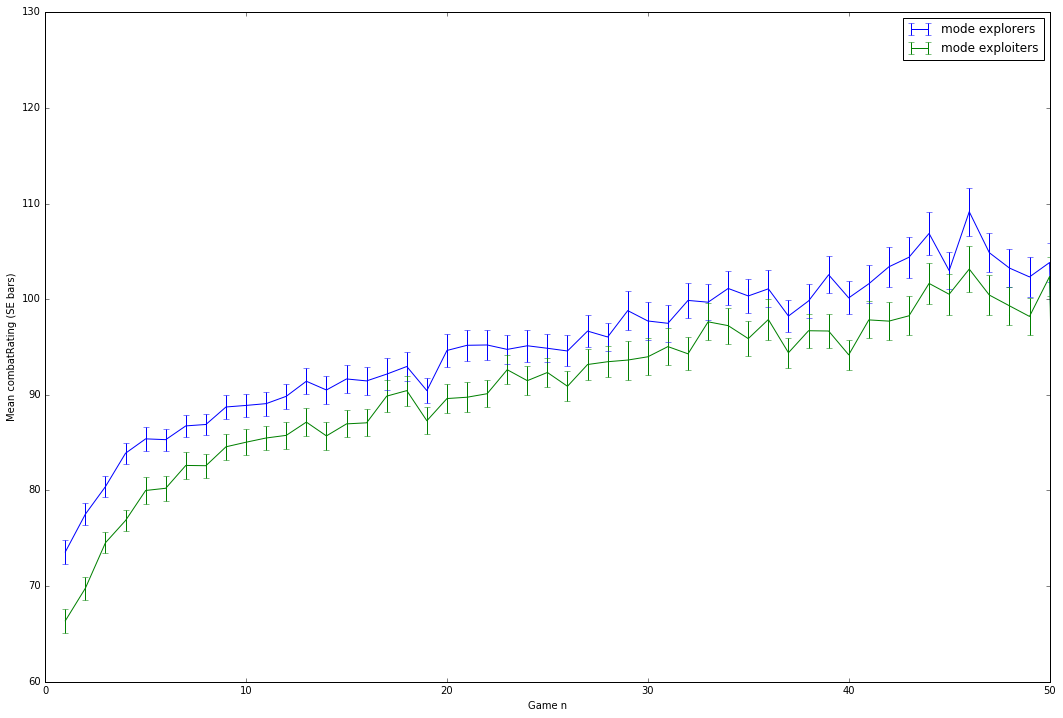

In [21]:
plt.clf()
xvals=range(1,minplay+2)

mask=sf['destinyMembershipId'].isin(mode_explorers_) & (sf['max_plays']>(minplay)) & (sf['max_plays']<(maxplay))  & np.isfinite(sf[perfvar])
yvals=sf[mask].groupby('game_n')[perfvar].mean()    
yvals=sf[mask].groupby('game_n')[perfvar].mean()    
ysems=sf[mask].groupby('game_n')[perfvar].sem()    
yvals=yvals[:minplay];ysems=ysems[:minplay]
yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
plt.errorbar(xvals,yvals,yerr=ysems,label='mode explorers')

mask=sf['destinyMembershipId'].isin(mode_exploiters) & (sf['max_plays']>(minplay)) & (sf['max_plays']<(maxplay)) & np.isfinite(sf[perfvar])
yvals=sf[mask].groupby('game_n')[perfvar].mean()    
yvals=sf[mask].groupby('game_n')[perfvar].mean()    
ysems=sf[mask].groupby('game_n')[perfvar].sem()    
yvals=yvals[:minplay];ysems=ysems[:minplay]
yvals[0]=0;ysems[0]=0 #see here for why I have to do this  http://stackoverflow.com/questions/35137961/pandas-plotting-with-yerr-gives-key-error-0        
plt.errorbar(xvals,yvals,yerr=ysems,label='mode exploiters')

plt.xlim([0,minplay])
plt.ylim([cRmin,cRmax])
plt.xlabel('Game n')
plt.ylabel('Mean ' + perfvar + ' (SE bars)')
#plt.annotate(labeltext,xy=(minimum_plays*0.8, .55),xycoords='data')
plt.legend(loc=0);

Although those who start of with higher performance also have higher game mode entropy, there is no indication that exploration of the game mode leads to greater learning

## Model: which factors predict learning
    
We fit a linear regression to each players play number vs performance data, extracting the slope and the intercept as crude gauges of both their performance on game 1 and the rate of improvement in their performance.

We then enter all the variables considered into a single regression model to try and predict these players characteristics

In [29]:
players['KDRslope']=np.NaN
players['KDRintercept']=np.NaN
players['KDRstd_err']=np.NaN
players['CR_slope']=np.NaN
players['CR_intercept']=np.NaN
players['CR_std_err']=np.NaN


total_n=len(players)
countn=0

for i,group in sf.groupby('destinyMembershipId')[[perfvar,'game_n']]:
    countn+=1 
    
    #if countn%100==0:
    #    print("Now on " + str(countn) + " of " + str(total_n)) #progress indicator

    if (i in players['destinyMembershipId'].values):
        yKDR=group.sort('game_n')['killsDeathsRatio'].values
        yCR_=group.sort('game_n')[perfvar].values
        x=range(1,len(yKDR)+1)
                
              
        #plot regression lines for subset
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,yKDR.tolist())  
        players.loc[players.destinyMembershipId == i,'KDRslope'] = slope
        players.loc[players.destinyMembershipId == i,'KDRintercept']=intercept
        players.loc[players.destinyMembershipId == i,'KDRstd_err']=std_err
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,yCR_.tolist())  
        players.loc[players.destinyMembershipId == i,'CR_slope']=slope
        players.loc[players.destinyMembershipId == i,'CR_intercept']=intercept
        players.loc[players.destinyMembershipId == i,'CR_std_err']=std_err 

In [30]:
players[['destinyMembershipId','CR_slope','CR_intercept','max_plays','space25','assists_rate','grimZ','eventEntropy25']].to_csv('forR.csv')


In [31]:
#now it is easiest to run this in R
os.system("sudo Rscript regmodel.R"); #(except it doesn't work in jupyter for some reason)

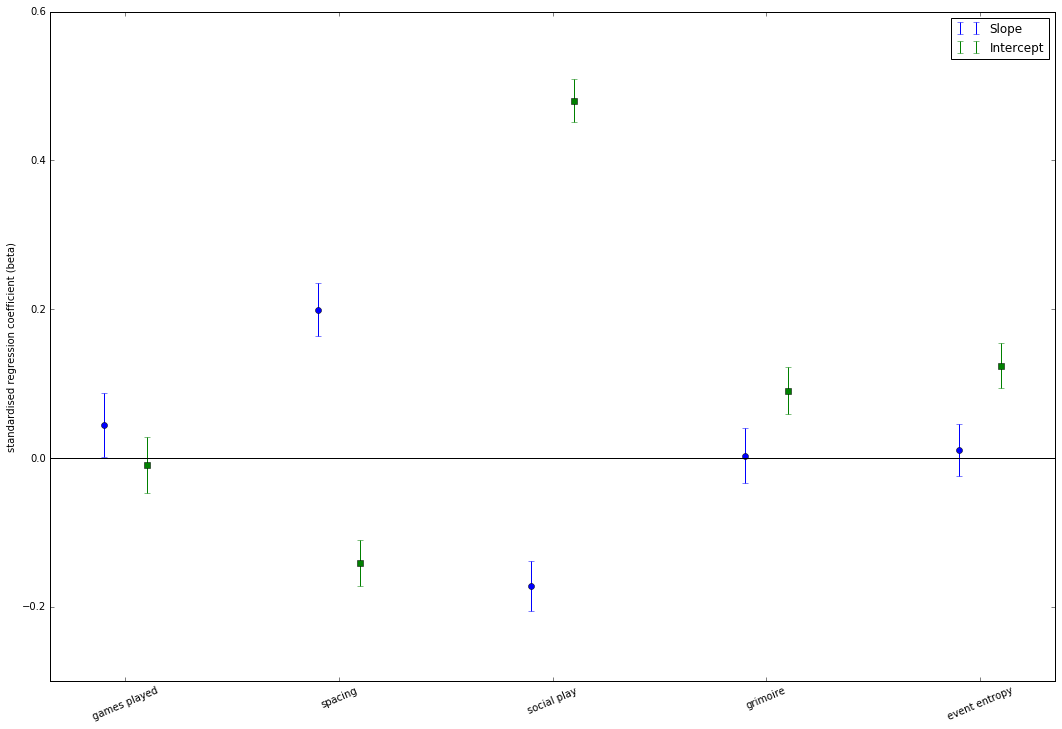

In [32]:
#now we can load data from regression
slope_betas=pd.read_csv("slope_betas.csv")
slope_se=pd.read_csv("slope_se.csv")
intercept_betas=pd.read_csv("intercept_betas.csv")
intercept_se=pd.read_csv("intercept_se.csv")

yvalsS=slope_betas[1:]['x'].values
ysemsS=slope_se[1:]['x'].values
yvalsI=intercept_betas[1:]['x'].values
ysemsI=intercept_se[1:]['x'].values

xvalsS=range(len(yvalsS))
xvalsI=[xv+0.2 for xv in xvalsS]
plt.clf()
plt.errorbar(xvalsS,yvalsS,yerr=ysemsS,marker='o',color='b',fmt='none',label='Slope')
plt.plot(xvalsS,yvalsS,marker='o',ls='',color='b')
plt.errorbar(xvalsI,yvalsI,yerr=ysemsI,marker='s',color='g',fmt='none',label='Intercept')
plt.plot(xvalsI,yvalsI,marker='s',ls='',color='g')
plt.plot([-1,5],[0,0],'k')
plt.ylabel('standardised regression coefficient (beta)')
plt.xlim([-0.25,4.45])
plt.legend(loc=0)

labels=['games played','spacing','social play','grimoire','event entropy']
plt.xticks([x+0.1 for x in xvalsS], labels, rotation=23);

Graph shows the standardised regression coefficient (beta, with SE bars) for each factor

Slope (learning rate) predictors are in blue

Intercept (initial performance) predictors are in green

Only spacing predicts enhanced learning (social play predicts slower learning)



--

Thanks for reading this far.

Reminders:

Paper: https://mindmodeling.org/cogsci2017/papers/0615/index.html  
Full scripts & sample data: https://osf.io/c59n9/  
Poster: http://tomstafford.staff.shef.ac.uk/docs/CogSci17_TomStafford.jpg  
This notebook: https://github.com/tomstafford/destiny/blob/master/variability.ipynb  